# start

from 0320_3_2_lang; random search for params with early stopping

- https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
- https://www.kaggle.com/c/liberty-mutual-group-property-inspection-prediction/discussion/15235

In [1]:
PRFX='0321_1'
trntmstmp=1584412344
valtmstmp=1584806233
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])

params = {
    'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['error', 'logloss'],
    'max_delta_step': 1,
}
num_rounds = 800

['2020-03-17 02:32:24', '2020-03-21 15:57:13']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [2]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [5]:
grand_total

150000000.0

In [6]:
grand_total/1e6

150.0

In [7]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e4#1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-21 14:35:50 chunk 0


In [8]:
df = pd.concat(lst_df)

In [9]:
df.shape

(10000, 95)

In [10]:
df.columns

Index(['u1_fllwer_cnt', 'u1_fllwng_cnt', 'u1_vrfed', 'u2_fllwer_cnt',
       'u2_fllwng_cnt', 'u2_vrfed', 'u1_fllw_u2', 'len_toks',
       'has_media_Photo', 'has_media_Video', 'has_media_GIF', 'num_hshtgs',
       'num_links', 'num_domns', 'twt_age', 'u1_age', 'u2_age', 'tm_dayofweek',
       'tm_hour', 'tmdlta_u2u1', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'twttyp_TopLevel', 'twttyp_Retweet',
       'twttyp_Quote', 'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
       'lang_22C448FF81263D4BAF2A176145EE9EAD',
       'lang_06D61DCBBE938971E1EA0C38BD9B5446',
       'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
       'lang_B9175601E87101A984A50F8A62A1C374',
       'lang_4DC22C3F31C5C43721E6B5815A595ED6',
       'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
       'lang_125C57F4FA6D4E110983FB11B52EFD4E',
       'lang_022EC308651FACB02794A8147AEE1B78',
       'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
       'lang_9BF3403E0EB7EA8A256DA9019C0B0716',
       'lang_975B38F44D65EE42A547283787FF5A

In [11]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [12]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 12.3 ms, sys: 4.11 ms, total: 16.4 ms
Wall time: 16.6 ms


In [13]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((8500, 91), (1500, 91), (8500, 4), (1500, 4))

# model

In [91]:
i=0
tgt=tgts[i]
ytri=ytr.iloc[:,i]
yvli=yvl.iloc[:,i]

In [92]:
fit_params = {
    'eval_set':[(Xvl,yvli)],
    'early_stopping_rounds':5,
    'eval_metric': ['error', 'auc', 'aucpr', 'logloss',],
    
}   

In [93]:
param_dists = {
    'learning_rate': [0.3, 0.1, 0.5, 0.05],
    'max_depth': [6, 4, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.5, 1, 2, 5],
    'subsample': [1.0, 0.8, 0.5],
    'colsample_bytree': [1.0, 0.8, 0.5],
    'max_delta_step': [0,1,5],
}

In [1]:
bst = xgb.XGBClassifier(objective='binary:logistic',
                        n_estimators=1000,
                        verbosity=0)
bst.fit(Xtr,ytri, **fit_params)

NameError: name 'bst' is not defined

In [94]:
bst = xgb.XGBClassifier(objective='binary:logistic',
                        n_estimators=1000,
                        verbosity=0)
scv = RandomizedSearchCV(
    estimator=bst,
    param_distributions=param_dists, 
    scoring='neg_log_loss',
    n_iter=2,
    verbose=1,
    cv=2)
scv.fit(Xtr,ytri, **fit_params)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[0]	validation_0-error:0.11800	validation_0-auc:0.50583	validation_0-aucpr:0.12594	validation_0-logloss:0.65630
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-error:0.11733	validation_0-auc:0.55358	validation_0-aucpr:0.21003	validation_0-logloss:0.62148
[2]	validation_0-error:0.11800	validation_0-auc:0.55092	validation_0-aucpr:0.20385	validation_0-logloss:0.58952
[3]	validation_0-error:0.11800	validation_0-auc:0.55153	validation_0-aucpr:0.19592	validation_0-logloss:0.56022
[4]	validation_0-error:0.11733	validation_0-auc:0.54810	validation_0-aucpr:0.20071	validation_0-logloss:0.53294
[5]	validation_0-error:0.11733	validation_0-auc:0.55149	validation_0-aucpr:0.20932	validation_0-logloss:0.50817
[6]	validation_0-error:0.11467	validation_0-auc:0.56478	validation_0-aucpr:0.22238	validation_0-logloss:0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[15]	validation_0-error:0.11733	validation_0-auc:0.64712	validation_0-aucpr:0.25529	validation_0-logloss:0.37738
[16]	validation_0-error:0.11733	validation_0-auc:0.64766	validation_0-aucpr:0.26152	validation_0-logloss:0.37137
[17]	validation_0-error:0.11667	validation_0-auc:0.64506	validation_0-aucpr:0.26073	validation_0-logloss:0.36639
[18]	validation_0-error:0.11667	validation_0-auc:0.64130	validation_0-aucpr:0.25961	validation_0-logloss:0.36296
[19]	validation_0-error:0.11733	validation_0-auc:0.64409	validation_0-aucpr:0.25974	validation_0-logloss:0.35970
[20]	validation_0-error:0.11667	validation_0-auc:0.64997	validation_0-aucpr:0.26556	validation_0-logloss:0.35566
[21]	validation_0-error:0.11667	validation_0-auc:0.65292	validation_0-aucpr:0.26622	validation_0-logloss:0.35293
[22]	validation_0-error:0.11667	validation_0-auc:0.65136	validation_0-aucpr:0.26920	validation_0-logloss:0.35042
[23]	validation_0-error:0.11667	validation_0-auc:0.65456	validation_0-aucpr:0.26851	validation_0

[24]	validation_0-error:0.11667	validation_0-auc:0.63886	validation_0-aucpr:0.23270	validation_0-logloss:0.35216
[25]	validation_0-error:0.11667	validation_0-auc:0.63971	validation_0-aucpr:0.22811	validation_0-logloss:0.35125
[26]	validation_0-error:0.11667	validation_0-auc:0.64187	validation_0-aucpr:0.23073	validation_0-logloss:0.34982
[27]	validation_0-error:0.11667	validation_0-auc:0.64092	validation_0-aucpr:0.22722	validation_0-logloss:0.34964
[28]	validation_0-error:0.11733	validation_0-auc:0.64370	validation_0-aucpr:0.23006	validation_0-logloss:0.34853
[29]	validation_0-error:0.11600	validation_0-auc:0.64269	validation_0-aucpr:0.23215	validation_0-logloss:0.34814
[30]	validation_0-error:0.11667	validation_0-auc:0.64493	validation_0-aucpr:0.23513	validation_0-logloss:0.34726
[31]	validation_0-error:0.11533	validation_0-auc:0.64910	validation_0-aucpr:0.23730	validation_0-logloss:0.34636
[32]	validation_0-error:0.11600	validation_0-auc:0.64684	validation_0-aucpr:0.23708	validation_0

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s finished


[8]	validation_0-error:0.11667	validation_0-auc:0.61306	validation_0-aucpr:0.23734	validation_0-logloss:0.44886
[9]	validation_0-error:0.11733	validation_0-auc:0.61605	validation_0-aucpr:0.23898	validation_0-logloss:0.43400
[10]	validation_0-error:0.11800	validation_0-auc:0.62142	validation_0-aucpr:0.24107	validation_0-logloss:0.42101
[11]	validation_0-error:0.11800	validation_0-auc:0.63944	validation_0-aucpr:0.23972	validation_0-logloss:0.41008
[12]	validation_0-error:0.11800	validation_0-auc:0.64663	validation_0-aucpr:0.24192	validation_0-logloss:0.40014
[13]	validation_0-error:0.11800	validation_0-auc:0.64978	validation_0-aucpr:0.24328	validation_0-logloss:0.39169
[14]	validation_0-error:0.11800	validation_0-auc:0.65480	validation_0-aucpr:0.23827	validation_0-logloss:0.38423
[15]	validation_0-error:0.11800	validation_0-auc:0.65357	validation_0-aucpr:0.22649	validation_0-logloss:0.37859
[16]	validation_0-error:0.11733	validation_0-auc:0.65233	validation_0-aucpr:0.23301	validation_0-l

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                   iid='deprecated', n_iter=2, n_jobs=None,
                   param_distributions={'colsample_bytree': [1.0, 0.8, 0.5],
                                        'ga

In [95]:
scv.cv_results_

{'mean_fit_time': array([0.61428738, 0.21130109]),
 'std_fit_time': array([0.02882719, 0.00934935]),
 'mean_score_time': array([0.07738233, 0.07256615]),
 'std_score_time': array([3.22270393e-03, 8.57114792e-05]),
 'param_subsample': masked_array(data=[1.0, 0.5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[5, 5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[6, 6],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_delta_step': masked_array(data=[1, 0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1, 0.5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0, 5],
              mask=[False, False],
        fill_value='

In [96]:
pd.DataFrame(scv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_max_delta_step,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.614287,0.028827,0.077382,0.003223,1,5,6,1,0.1,0,0.5,"{'subsample': 1.0, 'min_child_weight': 5, 'max...",-0.329582,-0.325335,-0.327458,0.002124,1
1,0.211301,0.009349,0.072566,0.000086,0.5,5,6,0,0.5,5,1,"{'subsample': 0.5, 'min_child_weight': 5, 'max...",-0.345507,-0.340950,-0.343229,0.002278,2


In [97]:
print(scv.best_score_)
print(scv.best_params_)


-0.32745846528581835
{'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 6, 'max_delta_step': 1, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}


https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

    early_stopping_rounds (int) – Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training. Requires at least one item in eval_set. The method returns the model from the last iteration (not the best one). If there’s more than one item in eval_set, the last entry will be used for early stopping. If there’s more than one metric in eval_metric, the last metric will be used for early stopping. If early stopping occurs, the model will have three additional fields: clf.best_score, clf.best_iteration and clf.best_ntree_limit.

In [98]:
bst_best = scv.best_estimator_

In [100]:
bst_best.evals_result()

{'validation_0': {'error': [0.118,
   0.118,
   0.117333,
   0.118,
   0.118,
   0.118,
   0.116667,
   0.118,
   0.116667,
   0.117333,
   0.118,
   0.118,
   0.118,
   0.118,
   0.118,
   0.118,
   0.117333,
   0.117333,
   0.117333,
   0.117333,
   0.117333,
   0.117333,
   0.117333,
   0.116667,
   0.117333,
   0.116667,
   0.115333,
   0.116,
   0.115333,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114667,
   0.114],
  'auc': [0.507341,
   0.54056,
   0.533367,
   0.542467,
   0.549436,
   0.556593,
   0.566814,
   0.577841,
   0.613063,
   0.61605,
   0.621424,
   0.639441,
   0.646632,
   0.649777,
   0.654795,
   0.653572,
   0.652327,
   0.652246,
   0.661416,
   0.670617,
   0.66656,
   0.670074,
   0.668289,
   0.668099,
   0.667077,
   0.669064,
   0.671943,
   0.671646

In [103]:
scv.predict_proba(Xvl)

array([[0.93913066, 0.06086932],
       [0.88174456, 0.11825542],
       [0.9666808 , 0.03331919],
       ...,
       [0.963422  , 0.03657801],
       [0.8563236 , 0.14367642],
       [0.833172  , 0.16682796]], dtype=float32)

In [104]:
bst_best.predict_proba(Xvl)

array([[0.93913066, 0.06086932],
       [0.88174456, 0.11825542],
       [0.9666808 , 0.03331919],
       ...,
       [0.963422  , 0.03657801],
       [0.8563236 , 0.14367642],
       [0.833172  , 0.16682796]], dtype=float32)

In [105]:
bst_best.predict_proba(Xvl, ntree_limit=bst_best.best_ntree_limit)

array([[0.93913066, 0.06086932],
       [0.88174456, 0.11825542],
       [0.9666808 , 0.03331919],
       ...,
       [0.963422  , 0.03657801],
       [0.8563236 , 0.14367642],
       [0.833172  , 0.16682796]], dtype=float32)

In [106]:
bst_best.best_score

0.334059

In [107]:
bst_best.best_iteration

45

In [108]:
bst_best.best_ntree_limit

46

# old

In [14]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
tgt2evalres={}
for i,tgt in enumerate(tgts):
    evals_result = {}
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                    evals=evallist, evals_result=evals_result, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-21 02:44:09 Retweet ********************************************************************************
[02:44:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-error:0.11034	train-logloss:0.58774	eval-error:0.11103	eval-logloss:0.58776
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[02:44:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.11002	train-logloss:0.50363	eval-error:0.11076	eval-logloss:0.50407
[02:44:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-error:0.10988	train-logloss:0.44028	eval-error:0.11075	eval-logloss:0.44084
[02:44:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6


[02:44:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-error:0.10847	train-logloss:0.30743	eval-error:0.10991	eval-logloss:0.31246
[02:44:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-error:0.10845	train-logloss:0.30726	eval-error:0.10995	eval-logloss:0.31241
[02:44:54] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[41]	train-error:0.10845	train-logloss:0.30711	eval-error:0.10995	eval-logloss:0.31236
[02:44:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[42]	train-error:0.10845	train-logloss:0.30702	eval-error:0.10993	eval-logloss:0.31237
[02:44:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-error:0.10839	train-logloss:0.30668	e

[02:45:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[79]	train-error:0.10766	train-logloss:0.30229	eval-error:0.10975	eval-logloss:0.31039
[02:45:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[80]	train-error:0.10763	train-logloss:0.30215	eval-error:0.10977	eval-logloss:0.31028
[02:45:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[81]	train-error:0.10759	train-logloss:0.30207	eval-error:0.10979	eval-logloss:0.31027
[02:45:28] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[82]	train-error:0.10759	train-logloss:0.30203	eval-error:0.10980	eval-logloss:0.31025
[02:45:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[83]	train-error:0.10759	train-logloss:0.30200	eval

[02:45:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[119]	train-error:0.10690	train-logloss:0.29864	eval-error:0.10957	eval-logloss:0.30987
[02:45:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[120]	train-error:0.10689	train-logloss:0.29862	eval-error:0.10957	eval-logloss:0.30988
[02:46:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[121]	train-error:0.10687	train-logloss:0.29857	eval-error:0.10956	eval-logloss:0.30989
[02:46:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[122]	train-error:0.10688	train-logloss:0.29850	eval-error:0.10954	eval-logloss:0.30989
[02:46:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[123]	train-error:0.10688	train-logloss:0.2983

[02:46:40] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[30]	train-error:0.02775	train-logloss:0.11029	eval-error:0.02716	eval-logloss:0.11155
[02:46:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[31]	train-error:0.02775	train-logloss:0.11016	eval-error:0.02716	eval-logloss:0.11152
[02:46:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[32]	train-error:0.02775	train-logloss:0.11007	eval-error:0.02716	eval-logloss:0.11153
[02:46:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[33]	train-error:0.02775	train-logloss:0.10996	eval-error:0.02717	eval-logloss:0.11152
[02:46:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[34]	train-error:0.02775	train-logloss:0.10987	eva

[02:47:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.34488	train-logloss:0.64438	eval-error:0.34702	eval-logloss:0.64519
[02:47:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-error:0.34342	train-logloss:0.63353	eval-error:0.34621	eval-logloss:0.63465
[02:47:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-error:0.34019	train-logloss:0.62640	eval-error:0.34323	eval-logloss:0.62774
[02:47:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-error:0.33953	train-logloss:0.62190	eval-error:0.34212	eval-logloss:0.62351
[02:47:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[5]	train-error:0.33775	train-logloss:0.61870	eval-

[02:47:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[41]	train-error:0.31534	train-logloss:0.59089	eval-error:0.32190	eval-logloss:0.59702
[02:47:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[42]	train-error:0.31487	train-logloss:0.59042	eval-error:0.32162	eval-logloss:0.59668
[02:47:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-error:0.31475	train-logloss:0.59027	eval-error:0.32154	eval-logloss:0.59659
[02:47:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[44]	train-error:0.31476	train-logloss:0.59018	eval-error:0.32131	eval-logloss:0.59653
[02:47:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[45]	train-error:0.31448	train-logloss:0.58996	eva

[02:48:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[81]	train-error:0.30964	train-logloss:0.58374	eval-error:0.31827	eval-logloss:0.59301
[02:48:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[82]	train-error:0.30943	train-logloss:0.58352	eval-error:0.31789	eval-logloss:0.59297
[02:48:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[83]	train-error:0.30931	train-logloss:0.58331	eval-error:0.31790	eval-logloss:0.59286
[02:48:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[84]	train-error:0.30922	train-logloss:0.58309	eval-error:0.31789	eval-logloss:0.59272
[02:48:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[85]	train-error:0.30897	train-logloss:0.58284	e

[02:49:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[121]	train-error:0.30497	train-logloss:0.57764	eval-error:0.31547	eval-logloss:0.58963
[02:49:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[122]	train-error:0.30484	train-logloss:0.57744	eval-error:0.31532	eval-logloss:0.58945
[02:49:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[123]	train-error:0.30459	train-logloss:0.57721	eval-error:0.31515	eval-logloss:0.58933
[02:49:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[124]	train-error:0.30446	train-logloss:0.57706	eval-error:0.31519	eval-logloss:0.58932
[02:49:04] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[125]	train-error:0.30435	train-logloss:0.576

[02:49:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[161]	train-error:0.30064	train-logloss:0.57243	eval-error:0.31321	eval-logloss:0.58699
[02:49:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[162]	train-error:0.30063	train-logloss:0.57242	eval-error:0.31322	eval-logloss:0.58698
[02:49:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[163]	train-error:0.30063	train-logloss:0.57238	eval-error:0.31323	eval-logloss:0.58696
[02:49:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[164]	train-error:0.30059	train-logloss:0.57234	eval-error:0.31320	eval-logloss:0.58697
[02:49:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[165]	train-error:0.30059	train-logloss:0.57233	

[02:50:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[201]	train-error:0.29657	train-logloss:0.56713	eval-error:0.31097	eval-logloss:0.58450
[02:50:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[202]	train-error:0.29652	train-logloss:0.56705	eval-error:0.31093	eval-logloss:0.58453
[02:50:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[203]	train-error:0.29648	train-logloss:0.56700	eval-error:0.31090	eval-logloss:0.58450
[02:50:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[204]	train-error:0.29643	train-logloss:0.56698	eval-error:0.31097	eval-logloss:0.58450
[02:50:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[205]	train-error:0.29624	train-logloss:0.56681

[02:50:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[241]	train-error:0.29313	train-logloss:0.56303	eval-error:0.30940	eval-logloss:0.58298
[02:50:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[242]	train-error:0.29300	train-logloss:0.56287	eval-error:0.30931	eval-logloss:0.58284
[02:50:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[243]	train-error:0.29286	train-logloss:0.56272	eval-error:0.30929	eval-logloss:0.58274
[02:50:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[244]	train-error:0.29276	train-logloss:0.56258	eval-error:0.30920	eval-logloss:0.58262
[02:50:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[245]	train-error:0.29265	train-logloss:0.56245	

[02:50:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[281]	train-error:0.28995	train-logloss:0.55935	eval-error:0.30823	eval-logloss:0.58192
[02:50:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[282]	train-error:0.28993	train-logloss:0.55932	eval-error:0.30822	eval-logloss:0.58193
[02:51:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[283]	train-error:0.28993	train-logloss:0.55928	eval-error:0.30825	eval-logloss:0.58192
[02:51:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[284]	train-error:0.28990	train-logloss:0.55925	eval-error:0.30827	eval-logloss:0.58191
[02:51:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[285]	train-error:0.28986	train-logloss:0.55922

[02:51:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[33]	train-error:0.00778	train-logloss:0.04156	eval-error:0.00759	eval-logloss:0.04262
[02:51:35] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[34]	train-error:0.00778	train-logloss:0.04149	eval-error:0.00759	eval-logloss:0.04260
[02:51:35] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[35]	train-error:0.00778	train-logloss:0.04137	eval-error:0.00759	eval-logloss:0.04258
[02:51:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[36]	train-error:0.00778	train-logloss:0.04132	eval-error:0.00759	eval-logloss:0.04258
[02:51:37] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[37]	train-error:0.00778	train-logloss:0.04126	eval

In [15]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

Retweet


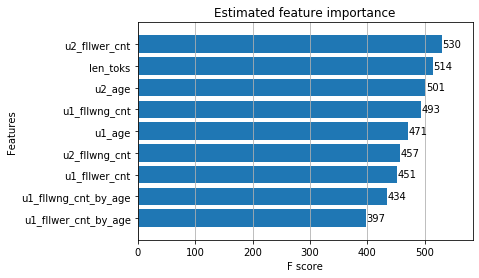

,0,1
6,u2_fllwer_cnt,530
3,len_toks,514
11,u2_age,501
4,u1_fllwng_cnt,493
18,u1_age,471
1,u2_fllwng_cnt,457
5,u1_fllwer_cnt,451
2,u1_fllwng_cnt_by_age,434
8,u1_fllwer_cnt_by_age,397
9,twt_age,352


Reply


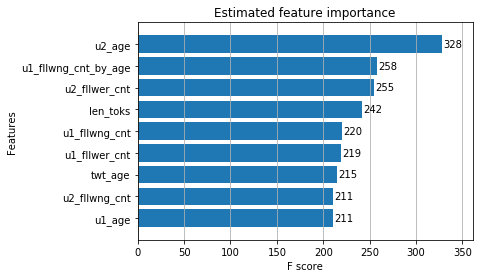

,0,1
0,u2_age,328
2,u1_fllwng_cnt_by_age,258
3,u2_fllwer_cnt,255
4,len_toks,242
9,u1_fllwng_cnt,220
7,u1_fllwer_cnt,219
10,twt_age,215
18,u2_fllwng_cnt,211
11,u1_age,211
1,u1_fllwer_cnt_by_age,210


Like


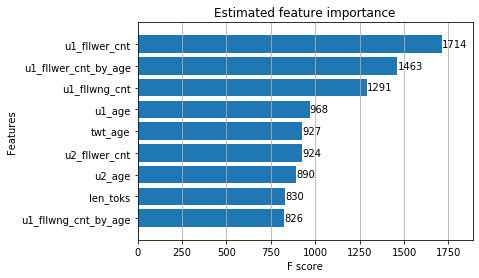

,0,1
5,u1_fllwer_cnt,1714
4,u1_fllwer_cnt_by_age,1463
20,u1_fllwng_cnt,1291
6,u1_age,968
14,twt_age,927
11,u2_fllwer_cnt,924
8,u2_age,890
3,len_toks,830
2,u1_fllwng_cnt_by_age,826
13,u2_fllwng_cnt,806


RTwCmnt


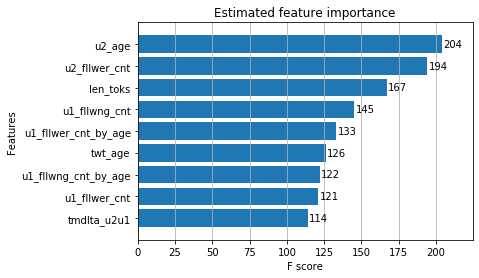

,0,1
0,u2_age,204
1,u2_fllwer_cnt,194
5,len_toks,167
9,u1_fllwng_cnt,145
11,u1_fllwer_cnt_by_age,133
10,twt_age,126
6,u1_fllwng_cnt_by_age,122
3,u1_fllwer_cnt,121
2,u2_fllwng_cnt,114
4,tmdlta_u2u1,114


In [16]:
for tgt,bst in tgt2bst.items():
    print(tgt)
    show_feat_importance(bst)

## valid

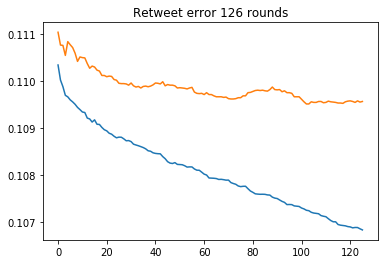

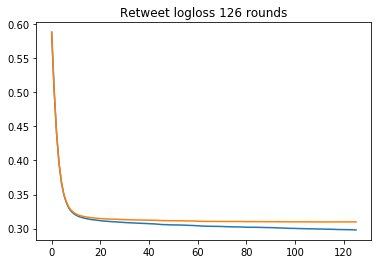

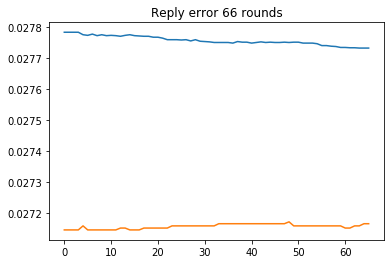

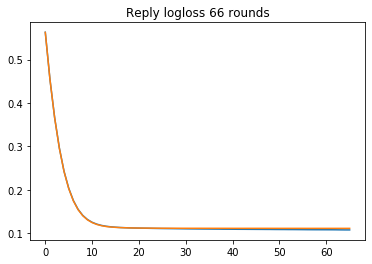

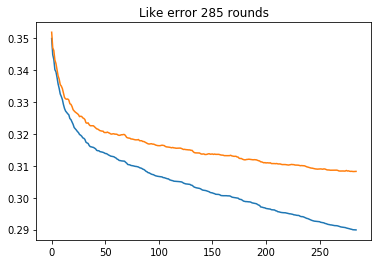

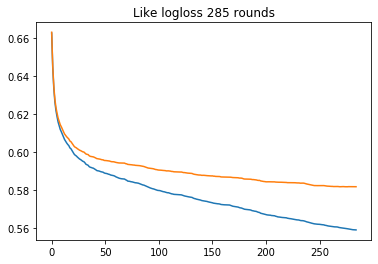

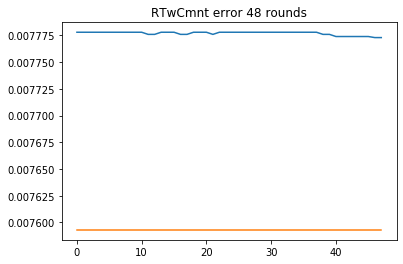

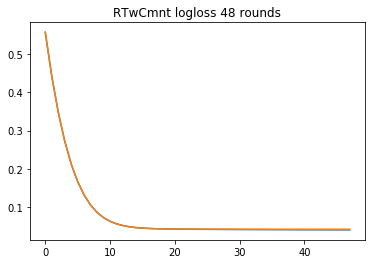

In [17]:
for tgt in tgts:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['error'])
    plt.plot(evalres['eval']['error'])
    plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
    plt.show()
    
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()

In [18]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr)
    tgt2prdvl[tgt] = bst.predict(dvl)
    

2020-03-21 02:51:48 Retweet
2020-03-21 02:51:49 Reply
2020-03-21 02:51:49 Like
2020-03-21 02:51:51 RTwCmnt


In [19]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7722 valid auc: 0.7443
train prauc: 0.3659 valid auc: 0.3179
train rce: 15.5252 valid rce: 12.3984
Reply
train rocauc: 0.8107 valid auc: 0.7709
train prauc: 0.1530 valid auc: 0.0935
train rce: 15.2062 valid rce: 10.6976
Like
train rocauc: 0.7782 valid auc: 0.7513
train prauc: 0.7330 valid auc: 0.6984
train rce: 18.4472 valid rce: 15.0775
RTwCmnt
train rocauc: 0.7909 valid auc: 0.7011
train prauc: 0.0658 valid auc: 0.0195
train rce: 10.5192 valid rce: 4.5635


In [20]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.365933,15.5252,0.152998,15.2062,0.732972,18.4472,0.0657798,10.5192
scrval,0.317854,12.3984,0.0935055,10.6976,0.698436,15.0775,0.0195177,4.56347


# infer

In [21]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 37s, sys: 8.99 s, total: 1min 46s
Wall time: 1min 46s


In [22]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 1min 53s, sys: 10.3 s, total: 2min 4s
Wall time: 2min 4s


In [23]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-21 02:57:52 Retweet
2020-03-21 02:58:02 Reply
2020-03-21 02:58:07 Like
2020-03-21 02:58:34 RTwCmnt
CPU times: user 13min 7s, sys: 36.5 s, total: 13min 43s
Wall time: 2min 50s


In [24]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [25]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-21 02:58:40 Retweet
2020-03-21 02:59:36 Reply
2020-03-21 03:00:33 Like
2020-03-21 03:01:29 RTwCmnt
CPU times: user 3min 39s, sys: 6.21 s, total: 3min 46s
Wall time: 3min 46s
